In [1]:
!pip -q install imbalanced-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ====== 1) LOAD DATA ======
# Option A: Upload manually
from google.colab import files
print("Upload your CSV (e.g., loan_approval_data.csv)")
uploaded = files.upload()

# Replace this with the actual uploaded filename (Colab shows the name in output)
CSV_FILENAME = list(uploaded.keys())[0]
df = pd.read_csv(CSV_FILENAME)

Upload your CSV (e.g., loan_approval_data.csv)


Saving loan_approval_dataset.csv to loan_approval_dataset.csv


In [3]:
# ====== 2) CLEANUP & BASIC EDA ======
# Normalize column names
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)

# Quick peek
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values:\n", df.isna().sum())

# Drop exact duplicates
before = len(df)
df = df.drop_duplicates()
print(f"\nDropped {before - len(df)} duplicate rows.")

# Ensure expected columns exist (soft-check, will adapt later)
expected_cols = [
    'loan_id','no_of_dependents','education','self_employed','income_annum',
    'loan_amount','loan_term','cibil_score','residential_assets_value',
    'commercial_assets_value','luxury_assets_value','bank_asset_value','loan_status'
]
missing_expected = [c for c in expected_cols if c not in df.columns]
if missing_expected:
    print("\n[Warning] These expected columns were not found:", missing_expected)

Shape: (4269, 13)

Columns: ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']

Missing values:
 loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

Dropped 0 duplicate rows.


In [4]:
# ====== 3) TARGET ENCODING ======
if 'loan_status' not in df.columns:
    raise ValueError("Target column 'loan_status' not found.")

# Robust mapping to binary: approved=1 (Y/Yes/Approved/1), else 0
y_text = df['loan_status'].astype(str).str.strip().str.lower()
pos_map = {'y','yes','approved','1','approved.'}
y = y_text.apply(lambda v: 1 if v in pos_map else 0)

# Remove target and non-feature ID
X = df.drop(columns=['loan_status'], errors='ignore')
if 'loan_id' in X.columns:
    X = X.drop(columns=['loan_id'])

In [5]:
# ====== 4) DTYPE CASTING ======
# Try to coerce numeric columns
numeric_candidates = [
    'no_of_dependents','income_annum','loan_amount','loan_term','cibil_score',
    'residential_assets_value','commercial_assets_value','luxury_assets_value','bank_asset_value'
]
for col in numeric_candidates:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Categorical columns (force to string if present)
categorical_candidates = ['education', 'self_employed']
for col in categorical_candidates:
    if col in X.columns:
        X[col] = X[col].astype(str).str.strip().fillna('')

# Auto-detect final numeric/categorical based on dtype and expected lists
numeric_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_features = [c for c in X.columns if c not in numeric_features]

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
Categorical features: ['education', 'self_employed']


In [6]:
# ====== 5) TRAIN/TEST SPLIT ======
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Optional: a small validation split for threshold tuning after we choose a model
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

In [7]:
# ====== 6) PREPROCESSOR ======
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

In [8]:
# ====== 7) MODELS & PIPELINES WITH SMOTE ======

log_reg = LogisticRegression(max_iter=500, n_jobs=None)  # n_jobs not used in LogisticRegression
dtree = DecisionTreeClassifier(random_state=42)

pipe_lr = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", log_reg)
])

pipe_dt = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", dtree)
])

# Hyperparameter grids (kept small/efficient for internship pace)
param_grid_lr = {
    "model__C": [0.1, 1.0, 3.0],
    "model__class_weight": [None, "balanced"],
    "smote__k_neighbors": [3, 5],
}
param_grid_dt = {
    "model__max_depth": [None, 6, 10],
    "model__min_samples_split": [2, 10, 20],
    "model__class_weight": [None, "balanced"],
    "smote__k_neighbors": [3, 5],
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid_lr,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=0
)
grid_dt = GridSearchCV(
    estimator=pipe_dt,
    param_grid=param_grid_dt,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=0
)

print("\nTraining Logistic Regression (with SMOTE + preprocessing)...")
grid_lr.fit(X_train, y_train)
print("Best LR params:", grid_lr.best_params_)
print("Best LR CV F1:", grid_lr.best_score_)

print("\nTraining Decision Tree (with SMOTE + preprocessing)...")
grid_dt.fit(X_train, y_train)
print("Best DT params:", grid_dt.best_params_)
print("Best DT CV F1:", grid_dt.best_score_)

# Choose best by CV F1
best_grid, best_name = (grid_lr, "Logistic Regression") if grid_lr.best_score_ >= grid_dt.best_score_ else (grid_dt, "Decision Tree")
best_model = best_grid.best_estimator_
print(f"\nSelected best model: {best_name}")


Training Logistic Regression (with SMOTE + preprocessing)...
Best LR params: {'model__C': 0.1, 'model__class_weight': None, 'smote__k_neighbors': 3}
Best LR CV F1: 0.9341309141565134

Training Decision Tree (with SMOTE + preprocessing)...
Best DT params: {'model__class_weight': None, 'model__max_depth': None, 'model__min_samples_split': 10, 'smote__k_neighbors': 5}
Best DT CV F1: 0.9804164057457688

Selected best model: Decision Tree



=== Decision Tree (Test) ===
ROC-AUC: 0.9834
PR-AUC (Average Precision): 0.9819

Classification Report (threshold=0.5):
               precision    recall  f1-score   support

           0     0.9720    0.9659    0.9689       323
           1     0.9794    0.9831    0.9812       531

    accuracy                         0.9766       854
   macro avg     0.9757    0.9745    0.9751       854
weighted avg     0.9766    0.9766    0.9766       854

Confusion Matrix:
 [[312  11]
 [  9 522]]


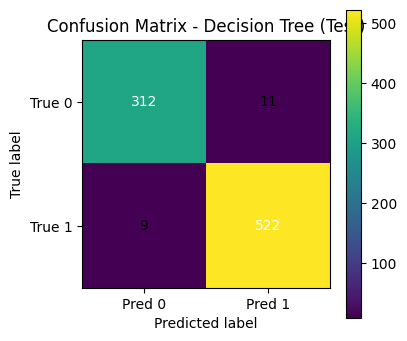

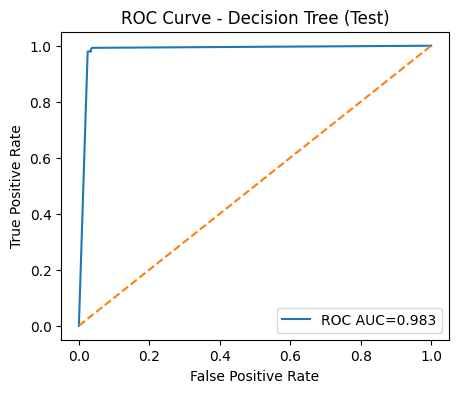

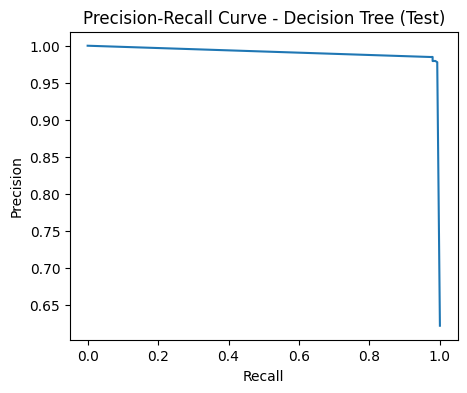

In [9]:
# ====== 8) FINAL EVALUATION ON TEST SET ======
def evaluate(model, X, y_true, title=""):
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4)
    roc = roc_auc_score(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)

    print(f"\n=== {title} ===")
    print("ROC-AUC:", round(roc, 4))
    print("PR-AUC (Average Precision):", round(ap, 4))
    print("\nClassification Report (threshold=0.5):\n", report)
    print("Confusion Matrix:\n", cm)

    # Confusion matrix heatmap
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(2), yticks=np.arange(2),
           xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'],
           title=f'Confusion Matrix - {title}', ylabel='True label', xlabel='Predicted label')
    # annotate
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'ROC AUC={roc:.3f}')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec)
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {title}')
    plt.show()

    return {"roc_auc": roc, "pr_auc": ap, "report": report, "cm": cm}

test_metrics = evaluate(best_model, X_test, y_test, title=f"{best_name} (Test)")

In [10]:
# ====== 9) THRESHOLD TUNING ON VALIDATION SPLIT ======
# We'll compute the threshold that maximizes F1 on the validation split.
y_val_prob = best_model.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, y_val_prob)

f1s = (2 * prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s[:-1])  # last precision/recall value has no threshold
best_thr = thr[best_idx]
print(f"\nBest threshold on validation (max F1): {best_thr:.4f}, F1={f1s[best_idx]:.4f}")

# Evaluate with tuned threshold on test
y_test_prob = best_model.predict_proba(X_test)[:, 1]
y_test_pred_tuned = (y_test_prob >= best_thr).astype(int)
print("\nClassification Report (Test, tuned threshold):\n",
      classification_report(y_test, y_test_pred_tuned, digits=4))
print("Confusion Matrix (Test, tuned threshold):\n",
      confusion_matrix(y_test, y_test_pred_tuned))


Best threshold on validation (max F1): 0.5000, F1=0.9988

Classification Report (Test, tuned threshold):
               precision    recall  f1-score   support

           0     0.9720    0.9659    0.9689       323
           1     0.9794    0.9831    0.9812       531

    accuracy                         0.9766       854
   macro avg     0.9757    0.9745    0.9751       854
weighted avg     0.9766    0.9766    0.9766       854

Confusion Matrix (Test, tuned threshold):
 [[312  11]
 [  9 522]]


In [11]:
# ====== 10) INTERPRETABILITY ======
# Get feature names after one-hot
def get_feature_names(preprocessor):
    feat_names = []
    if 'num' in preprocessor.named_transformers_:
        num_feats = preprocessor.transformers_[0][2]  # list of numeric input names
        feat_names.extend(num_feats)
    if 'cat' in preprocessor.named_transformers_:
        ohe = preprocessor.named_transformers_['cat'][-1]  # OneHotEncoder
        cat_input_names = preprocessor.transformers_[1][2]
        if hasattr(ohe, 'get_feature_names_out'):
            ohe_names = ohe.get_feature_names_out(cat_input_names)
        else:
            ohe_names = ohe.get_feature_names(cat_input_names)
        feat_names.extend(ohe_names.tolist())
    return feat_names

# Extract feature importances
try:
    # Works for Logistic Regression
    if isinstance(best_model.named_steps['model'], LogisticRegression):
        # Access the fitted preprocessor inside the pipeline
        fitted_pre = best_model.named_steps['preprocess']
        names = get_feature_names(fitted_pre)
        coefs = best_model.named_steps['model'].coef_.ravel()
        fi = pd.DataFrame({'feature': names, 'importance': np.abs(coefs), 'weight': coefs})
        fi = fi.sort_values('importance', ascending=False).head(20)
        print("\nTop 20 features by |weight| (Logistic Regression):")
        display(fi)
    # Works for Decision Tree
    elif isinstance(best_model.named_steps['model'], DecisionTreeClassifier):
        fitted_pre = best_model.named_steps['preprocess']
        names = get_feature_names(fitted_pre)
        importances = best_model.named_steps['model'].feature_importances_
        fi = pd.DataFrame({'feature': names, 'importance': importances})
        fi = fi.sort_values('importance', ascending=False).head(20)
        print("\nTop 20 features by importance (Decision Tree):")
        display(fi)
except Exception as e:
    print("[Info] Could not compute feature importances:", e)


Top 20 features by importance (Decision Tree):


,feature,importance
4,cibil_score,0.853747
3,loan_term,0.058528
2,loan_amount,0.035320
1,income_annum,0.021307
6,commercial_assets_value,0.011658
7,luxury_assets_value,0.010797
5,residential_assets_value,0.005746
0,no_of_dependents,0.002897
8,bank_asset_value,0.000000
9,education_Graduate,0.000000


In [12]:
# ====== 11) SAVE ARTIFACTS ======
MODEL_PATH = "loan_approval_best_pipeline.joblib"
joblib.dump(best_model, MODEL_PATH)
print(f"\nSaved best pipeline to: {MODEL_PATH}")


Saved best pipeline to: loan_approval_best_pipeline.joblib


In [37]:
# ====== 12) SIMPLE INFERENCE HELPER ======
def predict_loan_approval(sample_dict, pipeline, positive_label="Approved"):
    """
    sample_dict: Python dict with the same feature keys as training X, excluding loan_id.
    Returns: (proba_positive_class, label_str_using_0.5_threshold)
    """
    sample_df = pd.DataFrame([sample_dict])
    proba = pipeline.predict_proba(sample_df)[:, 1][0]
    label = positive_label if proba >= 0.5 else f"Not {positive_label}"
    return proba, label

# Example usage (edit the values as needed):
example = {
    "no_of_dependents": 3,              # Fewer dependents = less financial burden
    "education": "Not Graduate",            # Keep same
    "self_employed": "No",              # Keep same
    "income_annum": 120000,            # Much higher annual income
    "loan_amount": 10000,              # Lower requested loan
    "loan_term": 6,                     # Shorter repayment term
    "cibil_score": 820,                 # Very strong credit score
    "residential_assets_value": 8000, # Higher collateral
    "commercial_assets_value": 20000,  # Added more assets
    "luxury_assets_value": 50000,       # Extra collateral
    "bank_asset_value": 30000          # Higher bank balance
}

if set(example.keys()).issubset(set(X.columns)):
    proba, label = predict_loan_approval(example, best_model)
    print(f"\nExample prediction -> Probability Approved: {proba:.3f} | Label @0.5: {label}")
else:
    print("\n[Note] Example dict keys don't match your dataset columns exactly; adjust if needed.")


Example prediction -> Probability Approved: 0.333 | Label @0.5: Not Approved


In [23]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [24]:
import os

save_dir = "/content/drive/MyDrive/loan_approval"
os.makedirs(save_dir, exist_ok=True)

import joblib

model_path = os.path.join(save_dir, "loan_approval_best_pipeline.joblib")
joblib.dump(best_model, model_path)

print(f"Model saved to: {model_path}")


Model saved to: /content/drive/MyDrive/loan_approval/loan_approval_best_pipeline.joblib
